In [3]:
import pyabf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [4]:
data = "/Users/lingxinwang/Desktop/BrainSliceEphys/2023_10_09_0001.abf"

In [5]:
abf = pyabf.ABF(data)
print (abf)

ABF (v2.9) with 1 channel (pA), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 21.08 minutes, recorded with protocol "GAP FREE - 20 MIN".


In [6]:
# optional: if you have several sweeps/channels, select the right one
# abf.setSweep (sweepNumber = 1, channel =0)

# define the variables and sampling frequency
time = abf.sweepX     # in seconds
current = abf.sweepY
fs = int(abf.dataPointsPerMs *1000)

In [11]:
# pre-processing: adjust the baseline (detrend)
# a basic baseline adjustment can be done by subtracting a fixed value or the average of the full trace. For
# some voltage-clamp recordings, a linear detrend (scipy.detrend) might be also applied

# define the signal variable:  current or voltage
signal_raw = current

#subtract mean or median of the full trace
signal_adjusted = signal_raw - np.median (signal_raw)

# Option B: Subtract a fixed value
# signal_adjusted = signal_raw - 10

# Option C: Subtract a percentage of values with low activity
# signal_adjusted = signal_raw - np.percentile (signal_raw, 25) here 25%

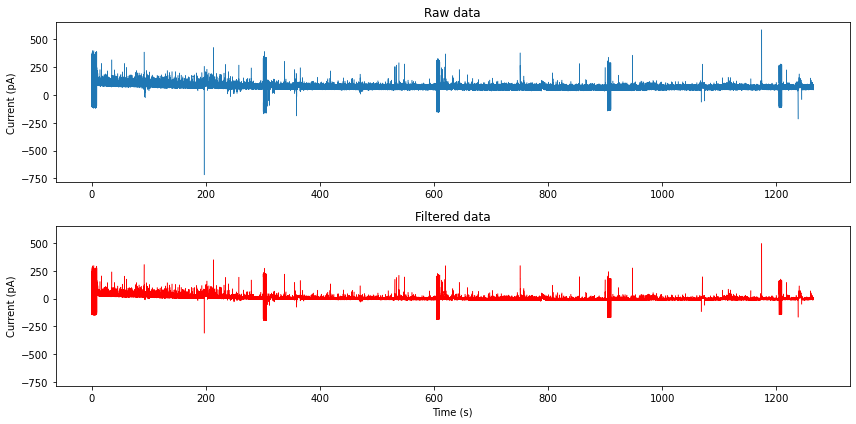

Standard deviation of the trace: 18.993410960593433


In [12]:
# pre-processing: filter the signal - do the filtering if your recording is noisy and has a lot of 
# high-frequency noise.

# lowpass bessel filter
b_lowpass, a_lowpass = signal.bessel (4, 2000, 'low', analog = False, norm = 'phase', fs=fs)

# Notch Besse filter 
b_notch, a_notch = signal.bessel (1, [59,61], 'bandstop', analog = False, fs=fs)

# Cobmine both filter
b_multiband = signal.convolve (b_lowpass, b_notch)
a_multiband = signal.convolve (a_lowpass, a_notch)

# For 2 filters
signal_filtered = signal.filtfilt(b_multiband, a_multiband, signal_adjusted)

# for 1 filter
# signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, signal_adjusted)

# Plot the raw trace
fig = plt.figure (figsize =(12,6))
ax1 = fig.add_subplot (211)
ax1.set_title("Raw data")
ax1.plot(time, current, linewidth = 0.5)

# Plot the filtered and adjusted trace
ax2 = fig.add_subplot (212, sharex=ax1, sharey=ax1)
ax2.set_title("Filtered data")
ax2.plot(time, signal_filtered, color='r', linewidth = 0.5)

# Plotting
ax1.set_ylabel ("Current (pA)")
ax2.set_ylabel ("Current (pA)")
ax2.set_xlabel ("Time (s)")
fig.tight_layout()

#show graph and table
plt.show()

# Standard deviation of the adjusted and filtered trace
std_trace = np.std(signal_filtered)
print ("Standard deviation of the trace:", std_trace)


Detection and analysis of synaptic events

-- There are two important considerations when usign the Find Peaks function. First, it works with positive values so for inward currents, use the symbol - in front of the data vatiable to convert the data to positive values. Second, the function only takes one-dimensional assays. That means that you need to recover the time information by, for instance, dividing the position of the peak by the sampling rate(s) or sampling rate/1000 (ms).
-- Threshold search could be used. Here I used a threshold of the standard deviation of the trace (19 pA here) and a minimus width of 1 ms. Then, I used a prominence of 3 SD. The prominence may be the most useful parameter to find peaks in unsteady traces because it takes the distance from the surrounding baseline. You can dig into the parameter definitions of the FindPeaks function. 
-- Parameters calculated by script as listed below. You can adapt it to either voltage or current recordings
* 'peak_index' - the index is the sampling point position at which an event is detected.
* 'peak_time_s' - the time in seconds at which an event is detected.
* 'event_start' - the index at which an event begins.
* 'event_end' - the sampling point at which an event ends.
* 'peak_amp' - in the example, the amplitude in picoamperes of the peak of an event.
* 'width_ms' - the width in milliseconds of an event, measured at half of its peak amplitude. 
* 'inst_freq' - event frequency (in Hz) at the rate of the currwnt and the previous event, calculated as the inverse of the inter-spike interval (ISI) between successive peaks of the event.
* 'isi_s' - the inter-spike interval (in seconds) between successive peaks of an event.
* 'area': in the example the area in PA.ms under the curve of an event, calculated as the integral of the signal over time.
* 'decay_tau_log': the logarithmic decay of an event's signal (in milliseconds), calculated as the ratio of the peak amplitude to the amplitude of the signal at a specified time point after the peak.
* 'decay_tau_exp': the exponential decay time constant (in milliseconds) of an event's signal, calculatd as the time constant of a single exponential function fitted to the decay phase of the event.
* 'rise_tau_exp' - as above but for the rising phase of the event.


<ipython-input-16-2c96c2794a53>:73: RuntimeWarning: overflow encountered in exp
  popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t),
<ipython-input-16-2c96c2794a53>:73: RuntimeWarning: overflow encountered in multiply
  popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t),
/Users/lingxinwang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:787: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/Users/lingxinwang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lingxinwang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-16-2c96c2794a53>:88: RuntimeWarning: overflow encountered in exp
  popt, pcov = curve_fit(lam

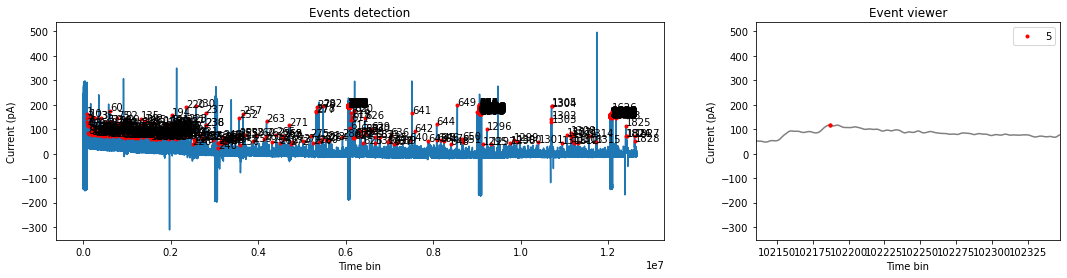

,event,peak_index,peak_time_s,event_window_start,event_window_end,peak_amp,width_ms,inst_freq,isi_s,area,decay_tau_log,decay_tau_exp,rise_tau_exp
0,1,90680,9.068,9.054220e+04,9.101887e+04,163.207,40.666,NaN,0.000,5803.62,67.557796,68.817414,29.004863
1,2,91723,9.172,9.166167e+04,9.187468e+04,129.584,14.301,9.588,0.104,2251.62,51.541066,49.899809,16.538806
2,3,93054,9.305,9.300413e+04,9.328996e+04,145.378,21.583,7.513,0.133,3225.42,66.095161,65.626387,5.815951
3,4,95449,9.545,9.527650e+04,9.569470e+04,112.196,34.820,4.175,0.240,3756.53,58.660311,57.14822,52.4852
4,5,102187,10.219,1.021353e+05,1.023474e+05,116.939,14.209,1.484,0.674,1793.33,33.310227,32.004692,6.487524
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,1824,12395788,1239.579,1.239575e+07,1.239602e+07,72.148,20.198,0.046,21.530,1279.1,56.681027,54.463645,2.008336
1824,1825,12398519,1239.852,1.239847e+07,1.239907e+07,115.064,52.810,3.662,0.273,3343.83,48.360054,1.0,2.345444
1825,1826,12418081,1241.808,1.241805e+07,1.241833e+07,72.134,20.318,0.511,1.956,1324.67,43.408674,42.396589,1.071985
1826,1827,12599252,1259.925,1.259882e+07,1.260015e+07,70.400,126.742,0.055,18.117,6741.97,139.635884,1.0,1.0


In [16]:
# define the signal variable: current or voltage (raw or processed)
peaks_signal = signal_filtered # trace after pre-processing

# You could also select a range of the trace with the below option
# peaks_signal = signal_filtered [5000:50000]

# Event wondow parameters
event_no = 4 # Event review: 0 is the first event
pretrigger_window = (2*fs)/1000 # Pre-event time window in ms
posttrigger_window = (5*fs)/1000 # Post-event time window in ms

# Set parameters of the Find Peaks function
thresh_min = 11
thresh_max = 200
thresh_prominence = 57
thresh_min_width = 0.5*(fs/1000)

# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, height=(thresh_min, thresh_max), #min and max threshold to detect peak
                              threshold = None, # min and max vertical distance to neighboring samples.
                              distance=None, # min horizontal distance between peaks.
                              prominence=thresh_prominence, #vertical distance between the peak and lowest contour line
                              width = thresh_min_width, #min required width (in bins). E.g. For 10 Khz, 10 bins = 1ms
                              wlen = None, #window length to calculate prominence 
                              rel_height=0.5, # Relative height at which the peak width is measured
                              plateau_size=None)

#Create table with results
table = pd.DataFrame(columns=['event', 'peak_index', 'peak_time_s', 'event_window_start', 'event_window_end', 
                             'peak_amp', 'width_ms', 'inst_freq', 'isi_s', 'area', 'decay_tau_log',
                             'decay_tau_exp', 'rise_tau_exp'])
table.event = np.arange(1, len(peaks)+1)
table.peak_index = peaks
table.peak_time_s = peaks/fs #Divided by fs to get s
table.event_window_start = peaks_dict['left_ips'] - pretrigger_window
table.event_window_end = peaks_dict ['right_ips'] + posttrigger_window
table.peak_amp = peaks_dict['peak_heights'] #height parameter is needed
table.width_ms = peaks_dict['widths']/(fs/1000) #width (ms) at half-height

# Additional parameters (remember to add the columns to the dataframe)
# table.rise_half_amp_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
# table.decay_half_amp_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
  
# Calculations based on the parameters above
table.inst_freq = np.insert((1 / (np.array(table.peak_index[1:]) -
                                  np.array(table.peak_index[:-1])) * fs), 
                            0, np.nan) 
 
table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
 
for i, event in table.iterrows():
     
    # Event area as absolute value (abs)
    individual_event = peaks_signal[int(event.event_window_start) : int(event.event_window_end)]
    table.loc[i, 'area'] = abs(round(individual_event.sum()/(fs/1000), 2))  #pA/ms
     
    # Decay tau from logistic regression
    decay_tau = abs(peaks_signal[int(event.peak_index) : int(event.event_window_end)])
    decay_tau_log = np.log(decay_tau)
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    slope, _ = np.polyfit(decay_width_array, decay_tau_log, 1)
    tau = -1 / slope
    table.loc[i, 'decay_tau_log'] = tau/(fs/1000) 
 
    # Decay tau from monoexponential fitting
    decay_tau = peaks_signal[int(event.peak_index) : int(event.event_window_end)]
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    a_initial = 200
    b_initial = 0.1
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           decay_width_array, decay_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=2000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'decay_tau_exp'] = abs((1/b)/(fs/1000))
     
    # Rise tau from monoexponential fitting
    rise_tau = peaks_signal[int(event.event_window_start):int(event.peak_index)]
    rise_width = int(len(rise_tau))
    rise_width_array = list(range(0, rise_width))
    a_initial = 200
    b_initial = 0.1
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           rise_width_array, rise_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=2000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'rise_tau_exp'] = abs((1/b)/(fs/1000))
 
     
# Plotting
fig = plt.figure(figsize=(18,4))
gridspec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
 
# Plot 1: Detected events in the trace
ax1 = fig.add_subplot(gridspec[0])  # gridspec specifies the ratio between plots
ax1.set_title("Events detection")   
ax1.plot(peaks_signal)
ax1.plot(peaks, peaks_signal[peaks], "r.")
for i, txt in enumerate(table.event):
    ax1.annotate(table.event[i], (peaks[i], peaks_signal[peaks][i]))
ax1.set_xlabel("Time bin")
ax1.set_ylabel("Current (pA)")
# ax1.axes.set_xlim(4000, 10000)  # OptionaL: Zoom in the trace
  
# Plot 2: Event viewer
ax2 = fig.add_subplot(gridspec[1]) 
ax2.set_title("Event viewer")
ax2.plot(peaks_signal, "gray")
ax2.plot(peaks, peaks_signal[peaks], "r.")
ax2.set_xlabel("Time bin")
ax2.set_ylabel("Current (pA)")
# Event time window
ax2.set_xlim(table.event_window_start[event_no], table.event_window_end[event_no]) 
# Labeling the event
line, = ax2.plot(peaks, peaks_signal[peaks], "r.") 
line.set_label(table.event[event_no]) 
ax2.legend()
        
# Show graph and table
plt.show()
table.round(3)  # round: display of decimal numbers in the table
